<a href="https://colab.research.google.com/github/IzumiSatoshi/deforumed-walk/blob/main/notebooks/deforum_with_d2i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# prepare initial image in advance

In [1]:
!pip install -q diffusers accelerate
!pip install -q numpngw timm einops
!pip install -q git+https://github.com/huggingface/transformers 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.6 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/IzumiSatoshi/deforumed-walk.git

Cloning into 'deforumed-walk'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 107 (delta 43), reused 78 (delta 23), pack-reused 0
Receiving objects: 100% (107/107), 6.51 MiB | 22.06 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [3]:
%cd deforumed-walk/

/content/deforumed-walk


In [120]:
import sys
sys.path.append("/content/deforumed-walk/src")
from warp import AnimArgs
from depth import DepthModel
import torch
import math
import py3d_tools as p3d
from einops import rearrange
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from diffusers import StableDiffusionDepth2ImgPipeline
from diffusers.schedulers import DPMSolverMultistepScheduler, DDIMScheduler, EulerAncestralDiscreteScheduler
from IPython import display
import time
from diffusers import DiffusionPipeline 
import torch 
import os

In [122]:
def transform_prev_img(prev_img: PIL.Image, prev_depth: torch.Tensor, device) -> PIL.Image:
    near=200,
    far=10_000,
    fov_deg=90,
    padding_mode="border"
    sampling_mode="bicubic"

    frame_idx = 0
    prev_img_numpy = np.array(prev_img)

    # x-> move camera left
    # y-> move camera up
    # z -> move camera backward :why?
    translate_xyz = [
        0,
        0,
        -0.1,
    ]

    # x -> look up
    # y -> look right
    # z -> counterclockwise
    rot_mat = p3d.euler_angles_to_matrix(
         torch.tensor([
             0,
             0,
             0,
         ], device=device),
         "XYZ"
     ).unsqueeze(0)
    
    # transform_image_3d
    torch.cuda.empty_cache()

    # adapted and optimized version of transform_image_3d from Disco Diffusion https://github.com/alembics/disco-diffusion
    w, h = prev_img_numpy.shape[1], prev_img_numpy.shape[0]
    aspect_ratio = float(w) / float(h)
    persp_cam_old = p3d.FoVPerspectiveCameras(
        near, far, aspect_ratio, fov=fov_deg, degrees=True, device=device
    )
    persp_cam_new = p3d.FoVPerspectiveCameras(
        near,
        far,
        aspect_ratio,
        fov=fov_deg,
        degrees=True,
        R=rot_mat,
        T=torch.tensor([translate_xyz]),
        device=device,
    )
    # range of [-1,1] is important to torch grid_sample's padding handling
    y, x = torch.meshgrid(
        torch.linspace(-1.0, 1.0, h, dtype=torch.float32, device=device),
        torch.linspace(-1.0, 1.0, w, dtype=torch.float32, device=device),
    )
    if prev_depth is None:
        z = torch.ones_like(x)
    else:
        z = torch.as_tensor(prev_depth, dtype=torch.float32, device=device)
    xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
    xyz_old_cam_xy = persp_cam_old.get_full_projection_transform().transform_points(
        xyz_old_world
    )[:, 0:2]
    xyz_new_cam_xy = persp_cam_new.get_full_projection_transform().transform_points(
        xyz_old_world
    )[:, 0:2]
    offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
    # affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
    identity_2d_batch = torch.tensor(
        [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]], device=device
    ).unsqueeze(0)
    # coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
    coords_2d = torch.nn.functional.affine_grid(
        identity_2d_batch, [1, 1, h, w], align_corners=False
    )
    offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h, w, 2)).unsqueeze(0)
    image_tensor = rearrange(
        torch.from_numpy(prev_img_numpy.astype(np.float32)), "h w c -> c h w"
    ).to(device)

    new_image = torch.nn.functional.grid_sample(
        image_tensor.add(1 / 512 - 0.0001).unsqueeze(0),
        offset_coords_2d,
        mode=sampling_mode,
        padding_mode=padding_mode,
        align_corners=False,
    )

    new_image = (
        rearrange(new_image.squeeze().clamp(0, 255), "c h w -> h w c")
        .cpu()
        .numpy()
        .astype(prev_img_numpy.dtype)
    )
    new_image = PIL.Image.fromarray(new_image)

    return new_image

def normalize_dsd_depth(dsd_depth):
    depth_norm = dsd_depth - dsd_depth.min()
    depth_norm = depth_norm / depth_norm.max()
    depth_norm = depth_norm

    return depth_norm

In [6]:
d2i_pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",
    revision="fp16",
    torch_dtype=torch.float16,
)

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/382 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/637 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/828 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/980 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/621 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [83]:
device = torch.device("cuda")

In [7]:
d2i_pipe.save_pretrained("/content/drive/MyDrive/models/diffusers/sd_depth2img_fp16")

In [8]:
d2i_pipe = d2i_pipe.to("cuda")

In [9]:
depth_model = DepthModel(torch.device("cuda"), "/content/drive/MyDrive/AI/models/dpt_large-midas-2f21e586.pt", half_precision=True)

In [10]:
init_image = PIL.Image.open("/content/drive/MyDrive/Project/deforumed_walk/paris.png")

prev_image = init_image
prev_depth = depth_model.predict(init_image)

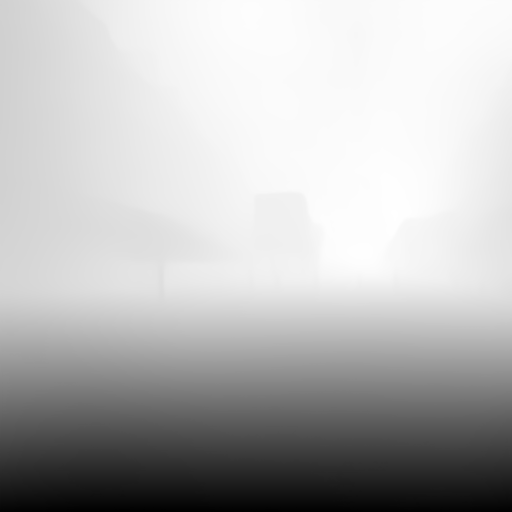

In [75]:
PIL.Image.fromarray((normalize_dsd_depth(prev_depth.cpu().numpy())*255).astype(np.uint8))

In [80]:
prev_depth_norm = normalize_dsd_depth(prev_depth)
prompt = "photographs taken while walking through the streets of Paris, POV, travel vlog, 4k, high quality"
negative_prompt = "low quality, low resolution, blurry, black and white"
prev_depth_norm[None]

tensor([[[0.8213, 0.8213, 0.8213,  ..., 0.9844, 0.9839, 0.9844],
         [0.8208, 0.8208, 0.8208,  ..., 0.9854, 0.9854, 0.9854],
         [0.8208, 0.8208, 0.8208,  ..., 0.9854, 0.9854, 0.9863],
         ...,
         [0.0240, 0.0227, 0.0227,  ..., 0.0149, 0.0143, 0.0136],
         [0.0182, 0.0182, 0.0188,  ..., 0.0110, 0.0110, 0.0104],
         [0.0162, 0.0169, 0.0175,  ..., 0.0084, 0.0084, 0.0097]]],
       device='cuda:0', dtype=torch.float16)

In [121]:

def save_pil(img:PIL.Image, folder_path, index):
    os.makedirs(folder_path, exist_ok=True)
    img.save(f"{folder_path}/{str(index).zfill(4)}.png")

99


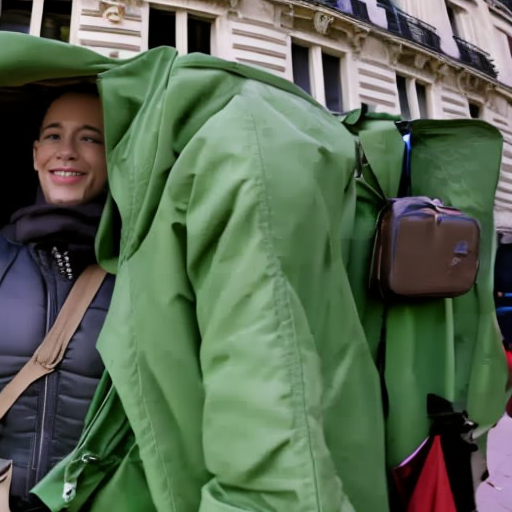

In [124]:
prev_img = init_image
folder_path = "/content/drive/MyDrive/Project/deforumed_walk/move_forward_around_paris_d2i"


save_pil(prev_img, folder_path, 0) 

for i in range(1, 100):
    prev_depth = depth_model.predict(prev_img)
    transformed_prev_img = transform_prev_img(prev_img, prev_depth, device)
    next_img = d2i_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt, 
        image=transformed_prev_img, 
        depth_map=None,
        strength=0.6
    ).images[0]

    save_pil(prev_img, folder_path, i) 
    display.clear_output(wait=True)
    print(i)
    display.display(next_img)

    prev_img = next_img

In [93]:
d = depth_model.predict(transformed_prev_img)

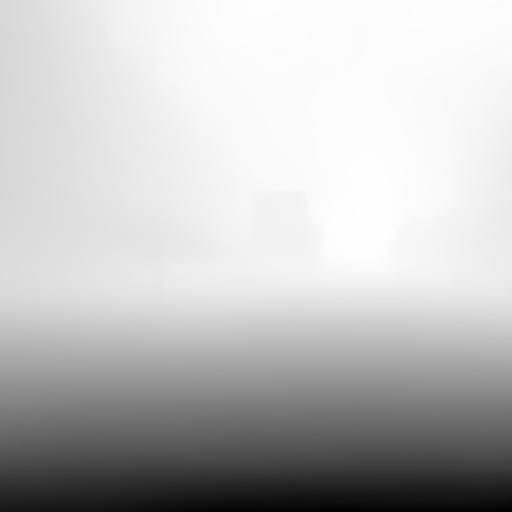

In [94]:
PIL.Image.fromarray((normalize_dsd_depth(d.cpu().numpy())*255).astype(np.uint8))